# Predictive Kozar Nonlinear

Copied from `Predictive Kozar.ipynb` to explore nonlinear combinations of predictors.  In this notebook we add products of the basic Kozar predictors to the predictor set.

There are a few different ways to do this, I choose to demean the predictors first and then form the NL combinations.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

In [2]:
# The range of years to gather data
YEARS = tuple(range(1878, 2020))
nyears = len(YEARS)

## Data gathering

In [3]:
counts = pd.read_csv('data_ibm/data.csv', index_col=0).loc[YEARS[0]:YEARS[-1], 'counts']

In [4]:
# This data output by data_ibm/Generate data.ipynb
kozar1 = pd.read_csv('data_ibm/data.csv', index_col=0).loc[YEARS[0]:YEARS[-1], ['mdr_aso', 'nino34_djf', 'nao_djfm']]

# This data is output by data/Generate MDR.ipynb
# Using April values
kozar2p = pd.read_csv('data/data_mdr.csv', index_col=0).loc[YEARS[0]:YEARS[-1], ['4']]
kozar2p.columns = ['mdr_p']

Data used in the Kozar 2012 paper

In [5]:
kozar_np = kozar1.copy()
# Incorporate an intercept
kozar_np.insert(0, "icpt", np.ones((kozar_np.shape[0],)))

Predictive version of Kozar

In [6]:
kozar = pd.concat([kozar2p, kozar1.loc[:, ['nino34_djf', 'nao_djfm']]], axis=1)
# Incorporate an intercept
kozar.insert(0, "icpt", np.ones((kozar.shape[0],)))

We now have a few datasets:
- `counts` are the VK08 corrected counts
- `kozar_np` the "non-predictive" data used in Kozar 2012
- `kozar` is the "predictive" data using April MDR temperatures

## Define cross-validation periods

In [7]:
assert len(YEARS) == 142
cv_batch_idxs = [np.arange(2, 2+28), np.arange(2+28, 2+28*2), np.arange(2+28*2, 2+28*3), np.arange(2+28*3, 2+28*4), np.arange(2+28*4, 2+28*5)]
num_batches = len(cv_batch_idxs)

Prepare the datasets for cross validation.  First use the `cv_batch_idxs` to split into batches

In [8]:
def get_cv_data(batch_idx, data, cv_batch_idxs=cv_batch_idxs):
    """
    pass in data of shape (observation, feature)
    returns the i^th training and validation data sets
    """
    if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series):
        data = data.values
    assert len(data.shape) <= 2
    if len(data.shape) == 1: # one-dimensional
        batches = [data[idxs] for idxs in cv_batch_idxs]
    else:
        batches = [data[idxs, :] for idxs in cv_batch_idxs]
    train = np.concatenate([c for (i, c) in enumerate(batches) if i != batch_idx], axis=0).copy()
    valid = batches[batch_idx].copy()
    return train, valid    

# Test some models

## Intercept

In [9]:
def test_icpt():
    params = []
    errs = []
    for bidx in range(num_batches):
        counts_train, counts_valid = get_cv_data(bidx, counts)
        err = np.mean(np.abs(counts_valid - np.mean(counts_train)))
        params.append(np.mean(counts_train))
        errs.append(err)
        print("{:d} {:f}".format(bidx, err))
    print()
    print("mean error = {:.4f}".format(np.mean(errs)))
    print("sdom error = {:.4f}".format(np.std(errs)/np.sqrt(len(errs))))
    return np.array(errs), params
errs_icpt, params_icpt = test_icpt()

0 2.648679
1 4.540209
2 2.228837
3 2.510242
4 5.243168

mean error = 3.4342
sdom error = 0.5448


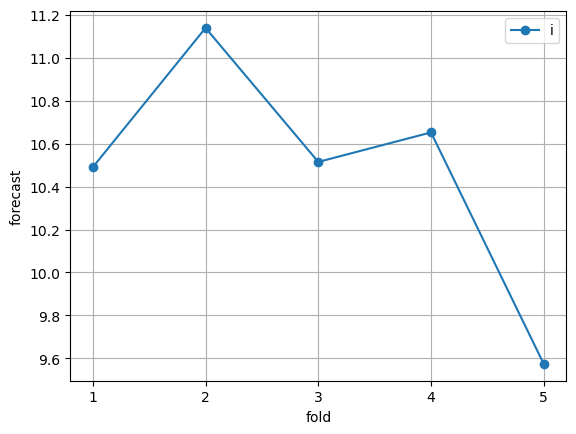

In [10]:
plt.plot(params_icpt, 'o-')
plt.xticks(range(5), range(1, 5+1))
plt.grid()
plt.legend(('intercept'))
plt.xlabel('fold')
plt.ylabel('forecast');

## Kozar 2012 (non-predictive)

In [11]:
def log_like(targets, forecast):
    return np.sum(targets * np.log(forecast) - forecast)


def calc_forecast(features, thetas):
    return np.exp(np.dot(features, thetas))


def make_objective(targets, features):
    # Log-Liklihood per observation has better gradient properties
    def foo(x):
        fc = calc_forecast(features, x)
        nobs = features.shape[0]
        return -log_like(targets, fc)/float(nobs)
    return foo


def clean(targets, features):
    # Return cleaned versions of targets and features
    good = np.logical_and(np.all(np.isfinite(features), axis=1), np.isfinite(targets))
    return targets[good], features[good, :]


def fit_poisson(targets, features):
    """
    Fit the model and deal with missing observations.  Note this scales up the 
    MSE.  Returns the betas.  Also return some additional information
    """
    # clean and fit
    t_, f_ = clean(targets, features)
    beta0 = np.zeros((f_.shape[1]))
    # solve
    res = sp.optimize.minimize(make_objective(t_, f_), beta0, method='L-BFGS-B')
    assert res.success
    return res.x

def fit_pr(targets_train, preds_train, pred_valid):
    """
    targets_train   (year,) counts
    pred_train  (year, pred) predictors
    """

    coefs = fit_poisson(targets_train, preds_train)
    # evalute the model on the validation set
    kozar_pred_valid = calc_forecast(pred_valid, coefs)
    return coefs, kozar_pred_valid

In [12]:
def test_kozar_np():
    errs = []
    params = []
    for bidx in range(num_batches):
        counts_train, counts_valid = get_cv_data(bidx, counts)
        kozar_train, kozar_valid = get_cv_data(bidx, kozar_np)
        # This step is important. We define mean temperatures using the training
        # data as a reference period, then using this mean in the validation period
        # This makes no difference in a Poisson regression: but makes it more 
        # interpretable and might matter in other fitting methods, so we do it here
        assert np.all(kozar_train[:, 0]==1)
        feat_means = np.mean(kozar_train[:, 1:], axis=0)
        # Demean training data
        train_dm = kozar_train.copy()
        train_dm[:, 1:] = kozar_train[:, 1:] - feat_means
        # Demean validation data
        valid_dm = kozar_valid.copy()
        valid_dm[:, 1:] = kozar_valid[:, 1:] - feat_means
        # Fit
        betas, preds = fit_pr(counts_train, train_dm, valid_dm)
        params.append(betas)
        err = np.mean(np.abs(preds - counts_valid))
        errs.append(err)
        print("{:d} {:f}".format(bidx, err))
    print()
    print("mean mae = {:.4f}".format(np.mean(errs)))
    print("sdom mae = {:.4f}".format(np.std(errs)/np.sqrt(len(errs))))
    return np.array(errs), params
errs_kozar_np, params_kozar_np = test_kozar_np()

0 2.271503
1 2.782778
2 2.376887
3 2.206847
4 2.671710

mean mae = 2.4619
sdom mae = 0.1011


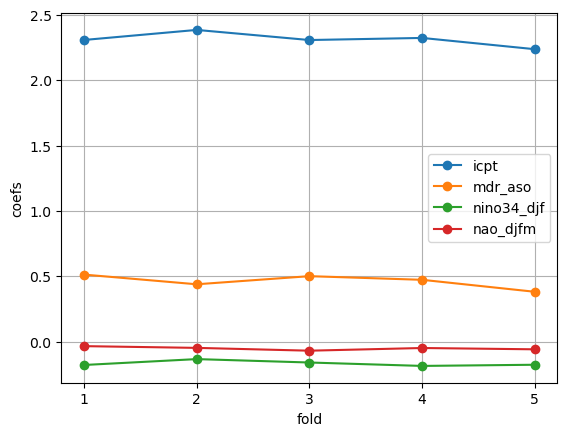

In [13]:
plt.plot(params_kozar_np, 'o-')
plt.xticks(range(5), range(1, 5+1))
plt.grid()
plt.legend(kozar_np.columns)
plt.xlabel('fold')
plt.ylabel('coefs');

## Predictive Kozar

In [14]:
def test_kozar():
    errs = []
    params = []
    for bidx in range(num_batches):
        counts_train, counts_valid = get_cv_data(bidx, counts)
        kozar_train, kozar_valid = get_cv_data(bidx, kozar)
        # This step is important. We define mean temperatures using the training
        # data as a reference period, then using this mean in the validation period
        # This makes no difference in a Poisson regression: but makes it more 
        # interpretable and might matter in other fitting methods, so we do it here
        assert np.all(kozar_train[:, 0]==1)
        feat_means = np.mean(kozar_train[:, 1:], axis=0)
        # Demean training data
        train_dm = kozar_train.copy()
        train_dm[:, 1:] = kozar_train[:, 1:] - feat_means
        # Demean validation data
        valid_dm = kozar_valid.copy()
        valid_dm[:, 1:] = kozar_valid[:, 1:] - feat_means
        # Fit
        betas, preds = fit_pr(counts_train, train_dm, valid_dm)
        params.append(betas)
        err = np.mean(np.abs(preds - counts_valid))
        errs.append(err)
        print("{:d} {:f}".format(bidx, err))
    print()
    print("mean mae = {:.4f}".format(np.mean(errs)))
    print("sdom mae = {:.4f}".format(np.std(errs)/np.sqrt(len(errs))))
    return np.array(errs), params
errs_kozar, params_kozar = test_kozar();

0 2.138035
1 3.186381
2 2.378595
3 2.718120
4 3.614084

mean mae = 2.8070
sdom mae = 0.2395


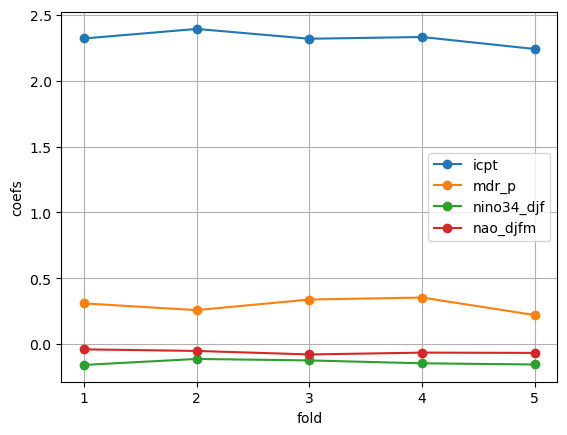

In [15]:
plt.plot(params_kozar, 'o-')
plt.xticks(range(5), range(1, 5+1))
plt.grid()
plt.legend(kozar.columns)
plt.xlabel('fold')
plt.ylabel('coefs');

## Comparison across models

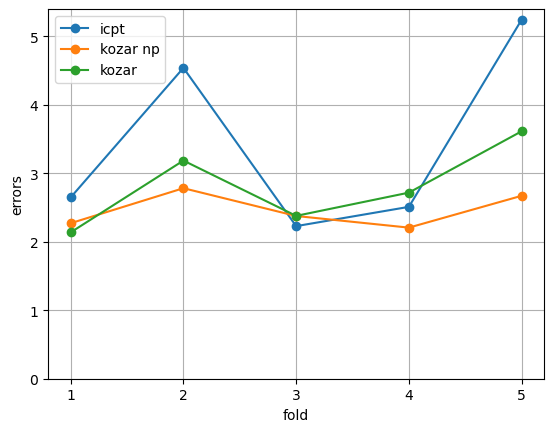

In [16]:
plt.plot(errs_icpt, 'o-')
plt.plot(errs_kozar_np, 'o-')
plt.plot(errs_kozar, 'o-')
plt.xticks(range(5), range(1, 5+1))
plt.xlabel('fold')
plt.ylabel('errors')
plt.grid()
plt.ylim(0, max(plt.ylim()))
plt.legend(('icpt', 'kozar np', 'kozar'))

In [17]:
def compare(errs1, errs2):
    srn = np.sqrt(len(errs1))
    def rpt(x):
        print("{:6.2f}  {:6.2f}  {:6.2f}".format(np.mean(x), np.std(x)/srn, srn*np.mean(x)/np.std(x)))
    print("  mean    sdom     z")
    rpt(errs1)
    rpt(errs2)
    rpt(errs1-errs2)

In [18]:
compare(errs_kozar_np, errs_icpt)

  mean    sdom     z
  2.46    0.10   24.35
  3.43    0.54    6.30
 -0.97    0.46   -2.13


In [19]:
compare(errs_kozar, errs_icpt)

  mean    sdom     z
  2.81    0.24   11.72
  3.43    0.54    6.30
 -0.63    0.34   -1.86


In [20]:
compare(errs_kozar, errs_kozar_np)

  mean    sdom     z
  2.81    0.24   11.72
  2.46    0.10   24.35
  0.35    0.17    2.01


## Nonlinear

In [21]:
def reg_std(x):
    return np.std(x) + 1e-6

In [22]:
def test_kozar_np_nl_1(prod1, prod2, verbose=True):
    """
    prod1 and prod2 are the indexes to use to form the product
    """
    errs = []
    params = []
    def concat_product(orig):
        return np.concatenate([orig, (orig[:, prod1] * orig[:, prod2]).reshape((-1,1))], axis=1)
    for bidx in range(num_batches):
        counts_train, counts_valid = get_cv_data(bidx, counts)
        kozar_train, kozar_valid = get_cv_data(bidx, kozar_np)
        # This step is important. We define mean temperatures using the training
        # data as a reference period, then using this mean in the validation period
        # This makes no difference in a Poisson regression: but makes it more 
        # interpretable and might matter in other fitting methods, so we do it here
        assert np.all(kozar_train[:, 0]==1)
        feat_means = np.mean(kozar_train[:, 1:], axis=0)
        # Demean training data
        train_dm = kozar_train.copy()
        train_dm[:, 1:] = kozar_train[:, 1:] - feat_means
        # Demean validation data
        valid_dm = kozar_valid.copy()
        valid_dm[:, 1:] = kozar_valid[:, 1:] - feat_means
        # Form nonlinear predictors
        train_dm = concat_product(train_dm)
        valid_dm = concat_product(valid_dm)
        # Fit
        betas, preds = fit_pr(counts_train, train_dm, valid_dm)
        params.append(betas)
        err = np.mean(np.abs(preds - counts_valid))
        errs.append(err)
        if verbose:
            print("{:d} {:f}".format(bidx, err))
    if verbose:
        print()
        print("mean mae = {:.4f}".format(np.mean(errs)))
        print("sdom mae = {:.4f}".format(np.std(errs)/np.sqrt(len(errs))))
    return np.array(errs), params

def test_kozar_np_nl():
    # List of products
    prod_list = [(i, j) for i in [1,2,3] for j in [1,2,3] if i <= j]

    # List of names
    cols = kozar_np.columns
    name_list = [cols[i] + " * " + cols[j] for (i, j) in prod_list]

    # For display
    prod_list = [(None, None)] + prod_list
    name_list = ["kozar_np"] + name_list

    # Reporting
    errs_kozar_np_nl = []
    params_kozar_np_nl = []
    print("    absolute      difference")
    print("  mean    sdom    mean     z     name")
    print("-" * 50)
    for n, (i, j) in zip(name_list, prod_list):
        if i is None:
            x = errs_kozar_np
        else:
            # do the fits
            x, y = test_kozar_np_nl_1(i, j, verbose=False)
            errs_kozar_np_nl.append(x)
            params_kozar_np_nl.append(y)

        # comparison with base (errs_kozar_np)
        # negative differences = lower error = good
        errs_base = errs_kozar_np
        srn = np.sqrt(len(errs_base))
        derrs = x - errs_base

        print(("{:6.2f}  " * 4 +  " {:s}").format(np.mean(x),
                                      np.std(x)/srn,
                                      np.mean(derrs),
                                      srn*np.mean(derrs)/reg_std(derrs), n))
    return errs_kozar_np_nl, params_kozar_np_nl, name_list

errs_kozar_np_nl, params_kozar_np_nl, names_kozar_np_nl = test_kozar_np_nl()

    absolute      difference
  mean    sdom    mean     z     name
--------------------------------------------------
  2.46    0.10    0.00    0.00   kozar_np
  2.63    0.19    0.16    1.30   mdr_aso * mdr_aso
  2.50    0.09    0.04    4.36   mdr_aso * nino34_djf
  2.47    0.10    0.00    0.37   mdr_aso * nao_djfm
  2.47    0.11    0.01    0.84   nino34_djf * nino34_djf
  2.43    0.11   -0.03   -4.71   nino34_djf * nao_djfm
  2.47    0.10    0.00    0.74   nao_djfm * nao_djfm


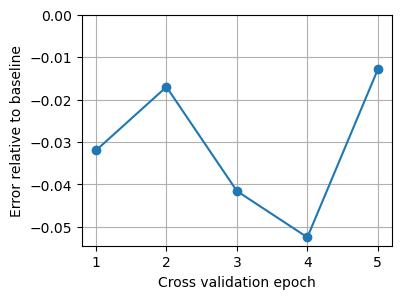

In [23]:
plt.figure(figsize=(4,3))
plt.plot(range(5), errs_kozar_np_nl[-2] - errs_kozar_np, 'o-')
plt.xticks(range(5), range(1,6))
plt.ylim((plt.ylim()[0], 0))
plt.xlabel('Cross validation epoch')
plt.ylabel('Error relative to baseline')
plt.grid();

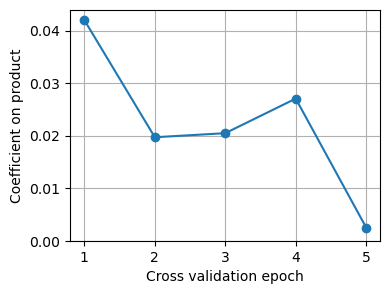

In [24]:
plt.figure(figsize=(4,3))
plt.plot(range(5), [x[-1] for x in params_kozar_np_nl[-2]], 'o-')
plt.xticks(range(5), range(1,6))
plt.ylim((0, plt.ylim()[1]))
plt.xlabel('Cross validation epoch')
plt.ylabel('Coefficient on product')
plt.grid();

It appears that the product of the second two predictors (`nino34` and `nao`) gives a statistically significant but small boost to forecast power.  The coefficient gets small in the last cross-validation period.

Now let's do the same test on predictive Kozar

In [25]:
def test_kozar_nl_1(prod1, prod2, verbose=True):
    """
    prod1 and prod2 are the indexes to use to form the product
    """
    errs = []
    params = []
    def concat_product(orig):
        return np.concatenate([orig, (orig[:, prod1] * orig[:, prod2]).reshape((-1,1))], axis=1)
    for bidx in range(num_batches):
        counts_train, counts_valid = get_cv_data(bidx, counts)
        kozar_train, kozar_valid = get_cv_data(bidx, kozar)
        # This step is important. We define mean temperatures using the training
        # data as a reference period, then using this mean in the validation period
        # This makes no difference in a Poisson regression: but makes it more 
        # interpretable and might matter in other fitting methods, so we do it here
        assert np.all(kozar_train[:, 0]==1)
        feat_means = np.mean(kozar_train[:, 1:], axis=0)
        # Demean training data
        train_dm = kozar_train.copy()
        train_dm[:, 1:] = kozar_train[:, 1:] - feat_means
        # Demean validation data
        valid_dm = kozar_valid.copy()
        valid_dm[:, 1:] = kozar_valid[:, 1:] - feat_means
        # Form nonlinear predictors
        train_dm = concat_product(train_dm)
        valid_dm = concat_product(valid_dm)
        # Fit
        betas, preds = fit_pr(counts_train, train_dm, valid_dm)
        params.append(betas)
        err = np.mean(np.abs(preds - counts_valid))
        errs.append(err)
        if verbose:
            print("{:d} {:f}".format(bidx, err))
    if verbose:
        print()
        print("mean mae = {:.4f}".format(np.mean(errs)))
        print("sdom mae = {:.4f}".format(np.std(errs)/np.sqrt(len(errs))))
    return np.array(errs), params

def test_kozar_nl():
    # List of products
    prod_list = [(i, j) for i in [1,2,3] for j in [1,2,3] if i <= j]

    # List of names
    cols = kozar.columns
    name_list = [cols[i] + " * " + cols[j] for (i, j) in prod_list]

    # For display
    prod_list = [(None, None)] + prod_list
    name_list = ["kozar"] + name_list

    # Reporting
    errs_kozar_nl = []
    params_kozar_nl = []
    print("    absolute      difference")
    print("  mean    sdom    mean     z     name")
    print("-" * 50)
    for n, (i, j) in zip(name_list, prod_list):
        if i is None:
            x = errs_kozar
        else:
            # do the fits
            x, y = test_kozar_nl_1(i, j, verbose=False)
            errs_kozar_nl.append(x)
            params_kozar_nl.append(y)

        # comparison with base (errs_kozar)
        # negative differences = lower error = good
        errs_base = errs_kozar
        srn = np.sqrt(len(errs_base))
        derrs = x - errs_base

        print(("{:6.2f}  " * 4 +  " {:s}").format(np.mean(x),
                                      np.std(x)/srn,
                                      np.mean(derrs),
                                      srn*np.mean(derrs)/reg_std(derrs), n))
    return errs_kozar_nl, params_kozar_nl, name_list

errs_kozar_nl, params_kozar_nl, names_kozar_nl = test_kozar_nl()

    absolute      difference
  mean    sdom    mean     z     name
--------------------------------------------------
  2.81    0.24    0.00    0.00   kozar
  2.88    0.27    0.08    1.85   mdr_p * mdr_p
  2.94    0.31    0.13    1.28   mdr_p * nino34_djf
  2.83    0.25    0.02    1.63   mdr_p * nao_djfm
  2.85    0.25    0.04    3.14   nino34_djf * nino34_djf
  2.81    0.24    0.00    0.09   nino34_djf * nao_djfm
  2.81    0.23    0.01    0.69   nao_djfm * nao_djfm


Nobody shows up in this one.  This is a little bit odd, since we did see some enhancement for the non-predictive version when the `nao * nino34` predictor was used.  Why doesn't it help here?  

- Perhaps the original result was just an accident. Seems unlikely since we got outperformance in 4/5 of the cross validation periods
- Perhaps for the non-predictive model the product predictor corrects something about the MDR predictor in-season
- Perhaps the pre-season is informative, and that information is already carried by `mdr_p` in the predictive model, while `mdr_aso` lacks that information.

## Does the pre-season MDR SST help?

This could be one explanation of the third possibility above

In [26]:
kozar_np_pre = pd.concat([ kozar_np.copy(), kozar.loc[:, 'mdr_p']], axis=1)

In [27]:
def test_kozar_np_pre():
    """
    Non-predictive (explanatory) Kozar with pre-season MDR SST
    """
    errs = []
    params = []
    for bidx in range(num_batches):
        counts_train, counts_valid = get_cv_data(bidx, counts)
        kozar_train, kozar_valid = get_cv_data(bidx, kozar_np_pre)
        # This step is important. We define mean temperatures using the training
        # data as a reference period, then using this mean in the validation period
        # This makes no difference in a Poisson regression: but makes it more 
        # interpretable and might matter in other fitting methods, so we do it here
        assert np.all(kozar_train[:, 0]==1)
        feat_means = np.mean(kozar_train[:, 1:], axis=0)
        # Demean training data
        train_dm = kozar_train.copy()
        train_dm[:, 1:] = kozar_train[:, 1:] - feat_means
        # Demean validation data
        valid_dm = kozar_valid.copy()
        valid_dm[:, 1:] = kozar_valid[:, 1:] - feat_means
        # Fit
        betas, preds = fit_pr(counts_train, train_dm, valid_dm)
        params.append(betas)
        err = np.mean(np.abs(preds - counts_valid))
        errs.append(err)
        print("{:d} {:f}".format(bidx, err))
    print()
    print("mean mae = {:.4f}".format(np.mean(errs)))
    print("sdom mae = {:.4f}".format(np.std(errs)/np.sqrt(len(errs))))
    return np.array(errs), params
errs_kozar_np_pre, params_kozar_np_pre = test_kozar_np_pre()

0 2.276683
1 2.790538
2 2.384004
3 2.215540
4 2.757826

mean mae = 2.4849
sdom mae = 0.1084


## Broader sets of candidate predictors

The Kozar 2012 paper studided the three "canonical" predictors `mdr_aso`, `nao_djfm`, `nino34_djf` as well as seven additional predictors.  Among these seven, some did not have data availability for the entire period.  Here we will look at all possible products.  These should be interpreted carefully since we are doing a lot of multiple hypothesis testing!

In [28]:
# This data output by data_ibm/Generate data.ipynb
cols = pd.read_csv('data_ibm/data.csv', index_col=0).columns
cols = [c for c in cols if c != 'counts']
fulldata = pd.read_csv('data_ibm/data.csv', index_col=0).loc[YEARS[0]:YEARS[-1], cols]
fulldata.insert(0, "icpt", np.ones((fulldata.shape[0],)))

# Indices of the canonical predictors
best3_idxs = [list(fulldata.columns).index(s) for s in ['mdr_aso', 'nino34_djf', 'nao_djfm']]
other_idxs = [i for i, s in enumerate(fulldata.columns) if i not in best3_idxs and s != 'icpt']

**IMPORTANT** two of the predictors `sahel_jjas` and `amm_jjasom` do not have values for the full sample.  In the raw dataframe they are treated as NaN.  Here I will do the easy thing and just replace them with 0s.  This will bias some of the fits and evaluations early in the sample

In [29]:
fulldata.fillna(0, inplace=True)

In [30]:
def test_full_np_nl_1(prod1, prod2, verbose=True):
    """
    prod1 and prod2 are the indexes to use to form the product
    """
    errs = []
    params = []
    def concat_product(orig):
        return np.concatenate([orig, (orig[:, prod1] * orig[:, prod2]).reshape((-1,1))], axis=1)
    for bidx in range(num_batches):
        counts_train, counts_valid = get_cv_data(bidx, counts)
        data_train, data_valid = get_cv_data(bidx, fulldata)
        # This step is important. We define mean temperatures using the training
        # data as a reference period, then using this mean in the validation period
        # This makes no difference in a Poisson regression: but makes it more 
        # interpretable and might matter in other fitting methods, so we do it here
        assert np.all(data_train[:, 0]==1)
        feat_means = np.mean(data_train[:, 1:], axis=0)
        # Demean training data
        train_dm = data_train.copy()
        train_dm[:, 1:] = data_train[:, 1:] - feat_means
        # Demean validation data
        valid_dm = data_valid.copy()
        valid_dm[:, 1:] = data_valid[:, 1:] - feat_means
        # Form nonlinear predictors
        train_nl = train_dm[:, prod1] * train_dm[:, prod2]
        valid_nl = valid_dm[:, prod1] * valid_dm[:, prod2]
        # Slice to canonical model and concatenate nonlinear predictor
        train_X = np.concatenate([train_dm[:, [0] + best3_idxs], train_nl.reshape((-1,1))], axis=1)
        valid_X = np.concatenate([valid_dm[:, [0] + best3_idxs], valid_nl.reshape((-1,1))], axis=1)
        # Fit
        betas, preds = fit_pr(counts_train, train_X, valid_X)
        params.append(betas)
        err = np.mean(np.abs(preds - counts_valid))
        errs.append(err)
        if verbose:
            print("{:d} {:f}".format(bidx, err))
    if verbose:
        print()
        print("mean mae = {:.4f}".format(np.mean(errs)))
        print("sdom mae = {:.4f}".format(np.std(errs)/np.sqrt(len(errs))))
    return np.array(errs), params

def test_full_np_nl():
    # Products of best predictors (already studied)
    prod_list_1 = [(i, j) for i in best3_idxs for j in best3_idxs if i <= j]
    # Mixture products
    prod_list_2 = [(i, j) for i in best3_idxs for j in other_idxs]
    # Products of other predictors
    prod_list_3 = [(i, j) for i in other_idxs for j in other_idxs if i <= j]
    prod_list = prod_list_1 + prod_list_2 + prod_list_3

    # List of names
    cols = fulldata.columns
    name_list = [cols[i] + " * " + cols[j] for (i, j) in prod_list]

    # For display
    prod_list = [(None, None)] + prod_list
    name_list = ["kozar_np"] + name_list

    # Reporting
    errs_kozar_np_nl = []
    params_kozar_np_nl = []
    print("    absolute      difference")
    print("  mean    sdom    mean     z     name")
    print("-" * 50)
    for n, (i, j) in zip(name_list, prod_list):
        if i is None:
            x = errs_kozar_np
        else:
            # do the fits
            x, y = test_full_np_nl_1(i, j, verbose=False)
            errs_kozar_np_nl.append(x)
            params_kozar_np_nl.append(y)

        # comparison with base (errs_kozar_np)
        # negative differences = lower error = good
        errs_base = errs_kozar_np
        srn = np.sqrt(len(errs_base))
        derrs = x - errs_base

        print(("{:6.2f}  " * 4 +  " {:s}").format(np.mean(x),
                                      np.std(x)/srn,
                                      np.mean(derrs),
                                      srn*np.mean(derrs)/reg_std(derrs), n))
    return errs_kozar_np_nl, params_kozar_np_nl

errs_full_np_nl, params_full_np_nl = test_full_np_nl()

    absolute      difference
  mean    sdom    mean     z     name
--------------------------------------------------
  2.46    0.10    0.00    0.00   kozar_np
  2.63    0.19    0.16    1.30   mdr_aso * mdr_aso
  2.50    0.09    0.04    4.36   nino34_djf * mdr_aso
  2.47    0.11    0.01    0.84   nino34_djf * nino34_djf
  2.43    0.11   -0.03   -4.71   nino34_djf * nao_djfm
  2.47    0.10    0.00    0.37   nao_djfm * mdr_aso
  2.47    0.10    0.00    0.74   nao_djfm * nao_djfm
  2.49    0.11    0.03    1.69   mdr_aso * sahel_jjas
  2.48    0.10    0.02    3.49   mdr_aso * nino12_djf
  2.49    0.09    0.03    2.78   mdr_aso * nino3_djf
  2.52    0.10    0.06    1.26   mdr_aso * relative_aso
  2.61    0.21    0.15    1.04   mdr_aso * tropic_aso
  2.49    0.10    0.03    0.88   mdr_aso * nao_mj
  2.47    0.10    0.01    1.72   mdr_aso * amm_jjasom
  2.52    0.14    0.06    1.06   nino34_djf * sahel_jjas
  2.48    0.10    0.02    2.85   nino34_djf * nino12_djf
  2.48    0.11    0.01    1.7

In [59]:
def comparison_table(*models):
    """
    Given a list of error series compute various observables and produce a LaTeX table.
    Arguments are a list of tuples with error timeseries
    comparison_table((name1, errs1), (name2, errs2), ...)
    """
    nfolds = None
    base_errs = None
    for ii, (name, errs) in enumerate(models):
        if nfolds is None:
            nfolds = len(errs)
        else:
            assert nfolds == len(errs), "different number of folds"
        srn = np.sqrt(nfolds)
        mean = np.mean(errs)
        sdom = np.std(errs)/srn
        s = "{:s}{:25s}{:s} & {:4.2f} & {:4.2f} ".format("\\texttt{", name.replace("_", "\_"), "}", mean, sdom)
        if ii == 0:
            base_errs = errs
            s += "&       &       &      \\\ "
        else:
            derrs = errs - base_errs
            mean_d = np.mean(derrs)
            sdom_d = np.std(derrs)/srn
            s += "& {:4.2f} & {:5.3f} & {:5.2f} \\\ ".format(mean_d, sdom_d, mean_d/sdom_d)
        print(s)

In [60]:
comparison_table(*[(n, e) for (n, e) in zip(names_kozar_np_nl, [errs_kozar_np] + errs_kozar_np_nl)])

\texttt{kozar\_np                } & 2.46 & 0.10 &       &       &      \\ 
\texttt{mdr\_aso * mdr\_aso      } & 2.63 & 0.19 & 0.16 & 0.126 &  1.30 \\ 
\texttt{mdr\_aso * nino34\_djf   } & 2.50 & 0.09 & 0.04 & 0.009 &  4.36 \\ 
\texttt{mdr\_aso * nao\_djfm     } & 2.47 & 0.10 & 0.00 & 0.009 &  0.37 \\ 
\texttt{nino34\_djf * nino34\_djf} & 2.47 & 0.11 & 0.01 & 0.013 &  0.84 \\ 
\texttt{nino34\_djf * nao\_djfm  } & 2.43 & 0.11 & -0.03 & 0.007 & -4.71 \\ 
\texttt{nao\_djfm * nao\_djfm    } & 2.47 & 0.10 & 0.00 & 0.007 &  0.74 \\ 


In [61]:
comparison_table(*[(n, e) for (n, e) in zip(names_kozar_nl, [errs_kozar] + errs_kozar_nl)])

\texttt{kozar                    } & 2.81 & 0.24 &       &       &      \\ 
\texttt{mdr\_p * mdr\_p          } & 2.88 & 0.27 & 0.08 & 0.042 &  1.85 \\ 
\texttt{mdr\_p * nino34\_djf     } & 2.94 & 0.31 & 0.13 & 0.103 &  1.28 \\ 
\texttt{mdr\_p * nao\_djfm       } & 2.83 & 0.25 & 0.02 & 0.012 &  1.63 \\ 
\texttt{nino34\_djf * nino34\_djf} & 2.85 & 0.25 & 0.04 & 0.012 &  3.14 \\ 
\texttt{nino34\_djf * nao\_djfm  } & 2.81 & 0.24 & 0.00 & 0.020 &  0.09 \\ 
\texttt{nao\_djfm * nao\_djfm    } & 2.81 & 0.23 & 0.01 & 0.011 &  0.69 \\ 


In [55]:
"mdr_aso".replace("_", "\_")

'mdr\\_aso'